# 3.6 Project F2: Make Accurate Measurements of Particle Masses

## 3.6.1 Goals of project
You will use LHCb data on the invariant mass of particle candidates that you were introduced
to during a checkpoint. You will analyse this in a much more sophisticated way, closer to the
actual analysis performed leading to its publication. You will use the maximum likelihood
process to fit different mass model shapes to the data. From this you will determine the
parameters of the mass model for the signal peaks, and their errors. You will start with a
very simple Gaussian mass model. You will then improve this and use a more sophisticated
model.
The projects have an open-ended aspect and are an opportunity where you can show your
own initiative and demonstrate your experimental and computational skills.
## 3.6.2 Equipment for project F2
This is a data handling exercise and the Raspberry Pi is not required, but can still be used.
You may find it faster to use the CPlab computers — there are several available in the DAH
laboratory. Alternatively you could use a personal laptop, but you will need to be able to
install Python and Python packages on your own.
## 3.6.3 Detailed project description
You were previously introduced to the LHCb Upsilon data. In this project you will explore
another LHCb dataset collected in 2011 where a pair of oppositely charged kaons and a pion
have been combined. Two clear peaks are observed in this mass spectrum corresponding
to the D+s (quark content cs) and D+ (quark content cd) mesons (charge conjugation is
implied), see figure below For more information see: DOI:10.1007/JHEP06(2013)065.

Download the files kkp.bin and kkpp.bin files from the DAH Dropbox, These files contain
the data recorded by LHCb in 2011 for D+
(s) and D0 decays respectively. Focus on the D+
(s)
data file (kkp.bin): The files are written in binary format and contain seven observables
• invariant mass of K+K−π+ candidate in MeV/c2
• invariant mass of kaon pair in MeV/c2
• transverse momentum of K+K−π+ candidate in GeV/c
• rapidity η of K+K−π+ candidate
• minimum tranverse momentum of the three tracks in the K+K−π+ candidate
• electric charge of the candidate
• polarity of the LHCb magnetic field
Write a Python script that reads the data from this file, see below.


In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy.integrate as integrate
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

In [2]:
f = open("kkp.bin","r")
b = np.fromfile(f,dtype=np.float32)
ncol = 7
# number of events
nevent = len(b)/ncol
xdata = np.split(b, nevent)
print(xdata[0])
# make list of invariant mass of events
xmass = []
for i in range(0, len(xdata)):
    xmass.append((xdata[i][0])/1000)
    if i < 10:
        print(xmass[i])

[ 2.0353304e+03  1.0168776e+03  7.0066626e+03  2.7526996e+00
  1.2672668e+03 -1.0000000e+00 -1.0000000e+00]
2.0353304443359375
1.97662109375
1.9516748046875
1.948279052734375
1.96346044921875
2.0428231201171876
1.974309814453125
1.963476318359375
1.9582470703125
1.954701904296875


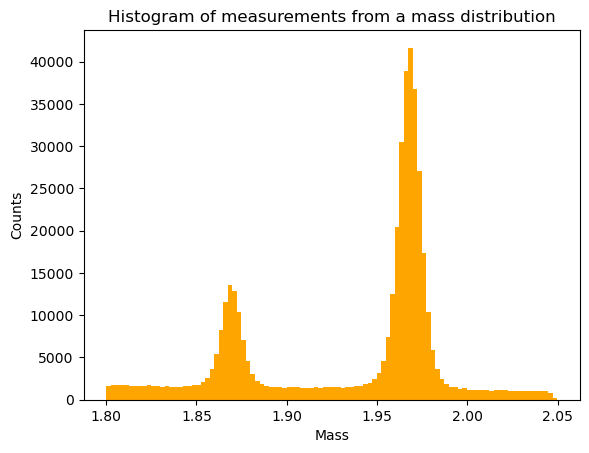

In [3]:
# Plotting as histogram to see the range of data
plt.hist(xmass, bins = 100, color='orange')
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

During checkpoint 6, you performed some very simple “peak finding.” In this project you
are going to do the analysis much like it would actually be carried out in a particle physics
experiment.

1. Consider first the D+ peak which is the particle with the lowest mass, i.e. the left
most peak in the plot. Construct a composite probability density function (PDF) for
the invariant mass of the muon pairs, which contains two components:
• A Gaussian shape to fit the D+ mass peak;
• A shallow falling exponential to fit the background shape of the mass spectrum
underneath and around the peak.

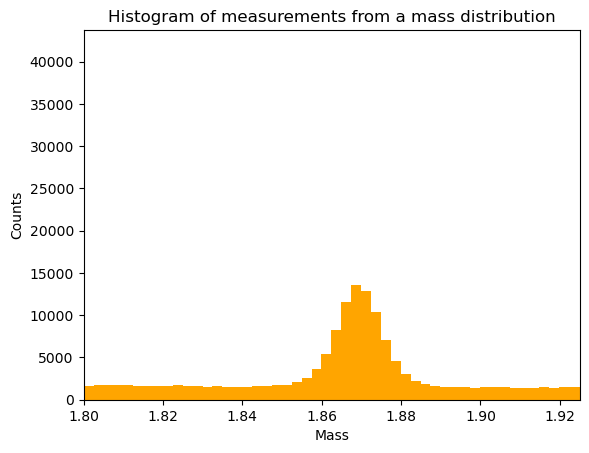

In [4]:
# Plotting as histogram to see the range of data
plt.hist(xmass, bins = 100, color='orange')
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.xlim([1.800, 1.925])
plt.show()

In [82]:
xmass_min=1.800
xmass_max=1.925

def norm_exp(x, tau):
    exp_norm_factor = np.exp(-xmass_min/tau) - np.exp(-xmass_max/tau)
            
    return ((1/(tau*exp_norm_factor))*np.exp(-x/tau))


def gauss(x, mu, sigma):         
    return np.exp(-0.5*((x-mu)/sigma)**2)


def norm_gauss(x, mu, sigma):
    
    #norm_gauss_factor, _ = integrate.quad(gauss, xmass_min, xmass_max, args = (mu, sigma))
    #norm_gauss = (1/norm_gauss_factor)*np.exp(-0.5*((x-mu)/sigma)**2)
    norm_gauss = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*(((x-mu)/sigma)**2))
    
    return norm_gauss


def composite_pdf(x, mu, sigma, tau, f, n):
    """
    Composite PDF.
        
    Args:

    """    
    return n*(f*norm_exp(x, tau) + (1-f)*norm_gauss(x, mu, sigma))

In [80]:
xmass = np.array(xmass)
xmass_dplus = xmass[(xmass <= xmass_max) & (xmass >= xmass_min)] 
print(len(xmass_dplus))

145710


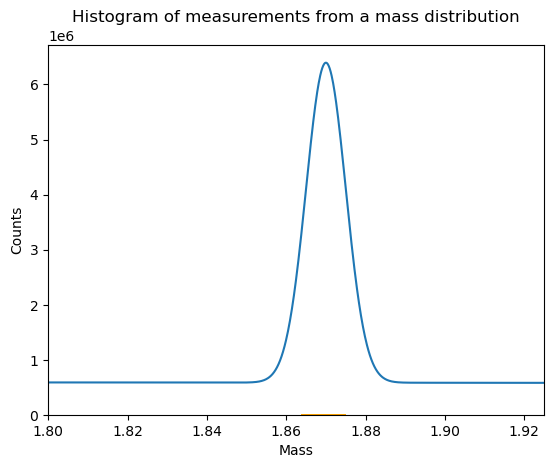

In [84]:
# Plotting
x = np.linspace(xmass_min, xmass_max, 1000)
y = composite_pdf(x, mu = 1.870, sigma = 0.005, tau = 10, f = 0.5, n = 145710
)

# Plotting as histogram to see the range of data
plt.hist(xmass_dplus, bins = 100, color='orange')
plt.plot(x, y)
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.xlim([1.800, 1.925])
plt.show()

2. Use this PDF in a Maximum Likelihood fit to determine the parameters of the PDF.
Note that it is essential that the composite PDF remains normalised to 1 over the
range of the fit.
Determine the D+ meson mass and yield, and all other parameters, and their errors.
You should be able to obtain the parameter errors directly from the minimization en-
gine of your choice (scipy.optimize.minimise, scipy.optimise.curve_fit, lmfit, see https:
//lmfit.github.io/lmfit-py/ or Minuit). Depending on your choice you will be able
to chose different minimising methods. It would be good to show that you understand
these by obtaining them yourself from the parameters of the Gaussian signal fit — this
is described in the data handling lectures.
Plot the fitted signal shape on top of the data.

In [78]:
nll = UnbinnedNLL(xmass_dplus, composite_pdf)
# set params to some vals
minuit = Minuit(nll, mu = 1.870, sigma = 0.005, tau = 10, f = 0.5, n = 145710)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.1, 0.1, 0.1, 0.1]
minuit.limits["f"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")
          

/home/kzatkova/anaconda3/envs/daml/lib/python3.9/site-packages/iminuit/cost.py:72: RuntimeWarning: invalid value encountered in log
  return np.log(x + 1e-323)
/tmp/ipykernel_49232/2104658259.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return ((1/(tau*exp_norm_factor))*np.exp(-x/tau))
/tmp/ipykernel_49232/2104658259.py:7: RuntimeWarning: invalid value encountered in multiply
  return ((1/(tau*exp_norm_factor))*np.exp(-x/tau))


mu = 1.87 +/- nan
sigma = 0.005 +/- nan
tau = 0.7639117700952766 +/- nan
f = 0.5 +/- nan
n = 145710.0 +/- nan


In [21]:
# Plotting
x = np.linspace(xmass_min, xmass_max, 1000)
y = composite_pdf(x, mu = 1.870, sigma = 0.005, tau = 0.871, f = 0.541)

# Plotting as histogram to see the range of data
plt.hist(xmass_dplus, bins = 100, color='orange')
plt.plot(x, y)
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.xlim([1.800, 1.925])
plt.show()

TypeError: composite_pdf() missing 1 required positional argument: 'n'

3. Now consider the entire mass range, and perform a simultaneous fit for both peaks,
and the underlying background. Again you should always report the parameter values,
and their errors. Plot the fitted signal shape on top of the data.

4. The results so far probably look quite good by eye, i.e. the signal shape plotted on
top of the data probably looks like it fits well. However this can be misleading when
performing a precision measurement. You should make a plot of what are called the
“residuals.” A residual is the difference between the data in the binned histogram and
the best-fit mass model value for the centre of that bin. Describe what you see.

5. There are several ways to enhance the scope of the project.
• If the single Gaussian mass model does not fit the data perfectly, one can try
other mass models, i.e. a signal PDF that goes beyond a single Gaussian func-
tion. One example is a PDF comprising a function which is the sum of two
Gaussian functions (i.e. one narrow and one wide Gaussian function to fit a sin-
gle D meson peak). Alternatively try a Crystal Ball function, which incorporates
a non-Gaussian tail at the lower end of the mass peak. The functional shape is de-
scribed elsewhere, e.g. see: https://en.wikipedia.org/wiki/Crystal_Ball_
function. You could implement each of these functions in your PDF and see how
much better they are at describing the data.
• Read the publication and see what is said about systematic errors. Make a rea-
sonable attempt at determining some systematic errors on the masses.
• Compare your results to the PDG and previous measurements.
• Study how the mass and the width of the peak (the resolution) depends on the
transverse momentum (p⊥) and rapidity (η).

3.6.4 Project planning
The project descriptions are generally significantly less detailed than what was made avail-
able for the checkpoints. Any material covered during checkpoints including python code
examples are assumed to be known. Only essential and new information is provided and you
are expected to take care of the details. Python code snippets are provided where necessary,
but you will have to understand yourself what they do. It is recommend that you google for
information about your project on the web, including data sheets of components and python
libraries, if applicable. Python scripts should be well structured, either using functions or
classes.
The timeline will vary between different projects, but in general, it is recommended that you
plan your work as follows:
• weeks 7, 8 & 9: Building your gadget and/or writing code for project;
• week 9, 10: Analysis of data or equivalent, prepare supplementary material;
• week 10, 11: Finish writing of project report and prepare submission.
Note that you are advised to start writing your report as the project progresses.
For guidance on report writing, how the projects will be assessed, plagiarism and the sub-
mission deadline, please consult the DAH course booklet and the DAH grade descriptors,
available on Learn.